# Test all dataset
ResNet50V2

In [ ]:
!pip install keras

In [ ]:
import numpy as np
import os
import cv2
import itertools
import random

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K


from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import ResNet50V2


import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim

In [ ]:
# All the images will be converted to the same size before processing
img_h, img_w = 120, 120

def preprocess_image(img_path):
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale

    # Check if the image is empty or None
    if image is None or len(image) == 0:
        print(f"Error: Image {img_path} is empty or None.")
        return None

    # Check if the image has valid dimensions
    if image.shape[0] == 0 or image.shape[1] == 0:
        print(f"Error: Image {img_path} has invalid dimensions.")
        return None

    # Resize image
    image = cv2.resize(image, (img_h, img_w))

    # Convert grayscale to RGB by replicating the channel
    image = cv2.merge((image, image, image))

    # Normalize pixel values
    image = image.astype('float32') / 255.0
    return image

# Function to generate batches
def generate_batch(orig_groups, forg_groups, batch_size=32):
    while True:
        pairs = [np.zeros((batch_size, img_h, img_w, 3)) for _ in range(2)]
        targets = np.zeros((batch_size,))

        for i in range(batch_size):
            if i < batch_size // 2:
                # Genuine-Genuine pairs
                pair_idx = np.random.randint(len(orig_groups), size=2)
                pair = (np.random.choice(orig_groups[pair_idx[0]]), np.random.choice(orig_groups[pair_idx[1]]))
                targets[i] = 1
            else:
                # Genuine-Forged pairs
                orig_idx = np.random.randint(len(orig_groups))
                orig = np.random.choice(orig_groups[orig_idx])
                forg = np.random.choice(forg_groups[orig_idx])
                pair = (orig, forg)
                targets[i] = 0

            # Preprocess images using preprocess_image function
            img1 = preprocess_image(pair[0])
            img2 = preprocess_image(pair[1])

            # Assign preprocessed images to pairs
            pairs[0][i, :, :, :] = img1
            pairs[1][i, :, :, :] = img2

        yield pairs, targets

# Load and preprocess data
path = "/content/drive/MyDrive/Multilingual dataset/BHSig260-Bengali"
dir_list = next(os.walk(path))[1]

orig_groups, forg_groups = [], []
for directory in dir_list:
    images = os.listdir(os.path.join(path, directory))
    images.sort()
    images = [os.path.join(path, directory, x) for x in images]
    forg_groups.append(images[:30])
    orig_groups.append(images[30:])

# Split data into train, validation, and test sets
orig_train, orig_val_test, forg_train, forg_val_test = train_test_split(orig_groups, forg_groups, test_size=0.2, random_state=42)
orig_val, orig_test, forg_val, forg_test = train_test_split(orig_val_test, forg_val_test, test_size=0.5, random_state=42)

# Define Siamese network model with ResNetV2 base
def get_siamese_model(input_shape):
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Add GlobalAveragePooling2D layer to reduce dimensions
    base_model = Sequential([
        base_model,
        GlobalAveragePooling2D()
    ])

    processed_a = base_model(input_a)
    processed_b = base_model(input_b)

    distance = Lambda(lambda x: tf.abs(x[0] - x[1]))([processed_a, processed_b])

    output = Dense(1, activation='sigmoid')(distance)

    model = Model(inputs=[input_a, input_b], outputs=output)
    return model

# Define batch size and generators
batch_size = 32
train_batch_generator = generate_batch(orig_train, forg_train, batch_size=batch_size)
val_batch_generator = generate_batch(orig_val_test, forg_val_test, batch_size=batch_size)
test_batch_generator = generate_batch(orig_test, forg_test, batch_size=batch_size)

# Compile model
input_shape = (img_h, img_w, 3)  # Adjusted input shape for RGB
model = get_siamese_model(input_shape)
model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=1e-4, rho=0.9, epsilon=1e-08))

# Define callbacks
callbacks = [
    EarlyStopping(patience=4, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('/content/drive/MyDrive/Multilingual dataset/Weights/Bengali-Weights/bengali-{epoch:03d}.h5',
                    verbose=1, save_best_only=True, save_weights_only=True)
]

# Train model
num_train_samples = sum(len(group) for group in orig_train + forg_train)
num_val_samples = sum(len(group) for group in orig_val_test + forg_val_test)
batches_per_epoch_train = num_train_samples // batch_size
batches_per_epoch_val = num_val_samples // batch_size

# Calculate steps per epoch
steps_per_epoch_train = max(1, num_train_samples // batch_size)
steps_per_epoch_val = max(1, num_val_samples // batch_size)

results = model.fit(
    train_batch_generator,
    steps_per_epoch=steps_per_epoch_train,  # Use calculated steps per epoch
    epochs=5,
    validation_data=val_batch_generator,
    validation_steps=steps_per_epoch_val,  # Use calculated steps per epoch for validation
    callbacks=callbacks
)


Epoch 1/5
135/135 [==============================] - ETA: 0s - loss: 0.5473 
Epoch 1: val_loss improved from inf to 0.59660, saving model to /content/drive/MyDrive/Multilingual dataset/Weights/Bengali-Weights/bengali-001.h5
135/135 [==============================] - 2206s 16s/step - loss: 0.5473 - val_loss: 0.5966 - lr: 1.0000e-04
Epoch 2/5
135/135 [==============================] - ETA: 0s - loss: 0.2356 
Epoch 2: val_loss did not improve from 0.59660
135/135 [==============================] - 2015s 15s/step - loss: 0.2356 - val_loss: 0.6620 - lr: 1.0000e-04
Epoch 3/5
135/135 [==============================] - ETA: 0s - loss: 0.0796 
Epoch 3: val_loss did not improve from 0.59660
135/135 [==============================] - 1979s 15s/step - loss: 0.0796 - val_loss: 0.7546 - lr: 1.0000e-04
Epoch 4/5
135/135 [==============================] - ETA: 0s - loss: 0.0463 
Epoch 4: val_loss did not improve from 0.59660
135/135 [==============================] - 1986s 15s/step - loss: 0.0463 - va

In [ ]:
# Load best weights
model.load_weights('/content/drive/MyDrive/Multilingual dataset/Weights/Bengali-Weights/bengali-001.h5')

In [ ]:
# Test model
test_batch_inputs, test_batch_labels = next(test_batch_generator)
predictions = model.predict(test_batch_inputs)

# Function to compute ROC curve
def compute_roc_curve(predictions, labels):
    fpr, tpr, thresholds = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, thresholds, roc_auc

# Compute ROC curve
fpr, tpr, thresholds, roc_auc = compute_roc_curve(predictions, test_batch_labels)

# Find the optimal threshold using Youden's J statistic
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Apply the optimal threshold to predictions
predictions_binary = (predictions > optimal_threshold).astype(int)

# Calculate metrics using the optimal threshold
accuracy = accuracy_score(test_batch_labels, predictions_binary)
precision = precision_score(test_batch_labels, predictions_binary)
recall = recall_score(test_batch_labels, predictions_binary)
f1 = f1_score(test_batch_labels, predictions_binary)

# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1-Score:", f1)
# print("Optimal Threshold:", optimal_threshold)
# print("ROC AUC:", roc_auc)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

1/1 [==============================] - 5s 5s/step
Accuracy: 0.84375
Precision: 0.7894736842105263
Recall: 0.9375
F1-Score: 0.8571428571428572


In [ ]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim

# Function to calculate SSIM between two images
def calculate_ssim(img1, img2):
    # Resize images to the same size
    img1_resized = cv2.resize(img1, (img_h, img_w))
    img2_resized = cv2.resize(img2, (img_h, img_w))

    score, _ = ssim(img1_resized, img2_resized, full=True)
    return score

# Calculate SSIM for each pair of images in the test set
ssim_scores = []
for img_batch1, img_batch2 in zip(test_batch_inputs[0], test_batch_inputs[1]):
    for img1, img2 in zip(img_batch1, img_batch2):
        ssim_score = calculate_ssim(img1.squeeze(), img2.squeeze())
        ssim_scores.append(ssim_score)

# Compute average SSIM score
average_ssim = sum(ssim_scores) / len(ssim_scores)
print("Average SSIM Score:", average_ssim)


Average SSIM Score: 0.8323302610170141


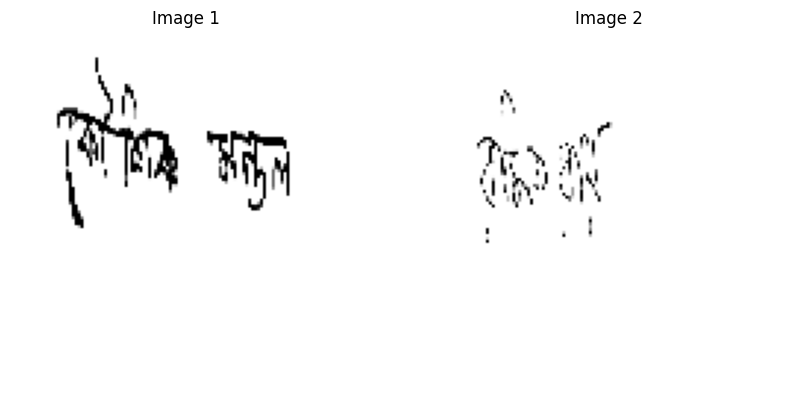

<ipython-input-20-dd6a53dd463a>:31: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = compare_ssim(img1.squeeze(), img2.squeeze(), win_size=win_size, multichannel=True)


SSIM Score: 0.7720814907527296


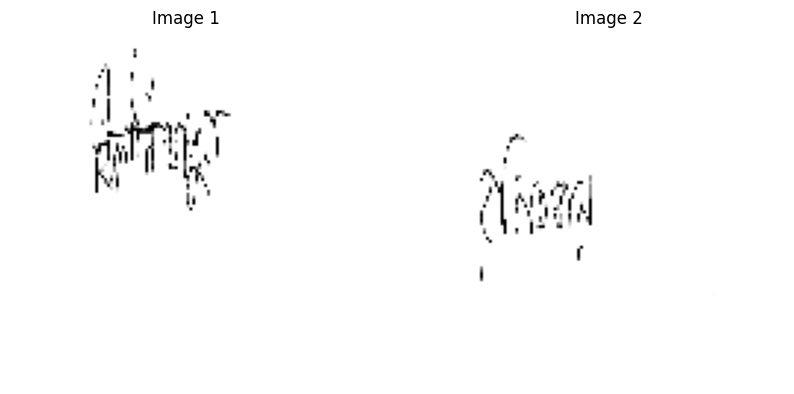

SSIM Score: 0.7821445238112713


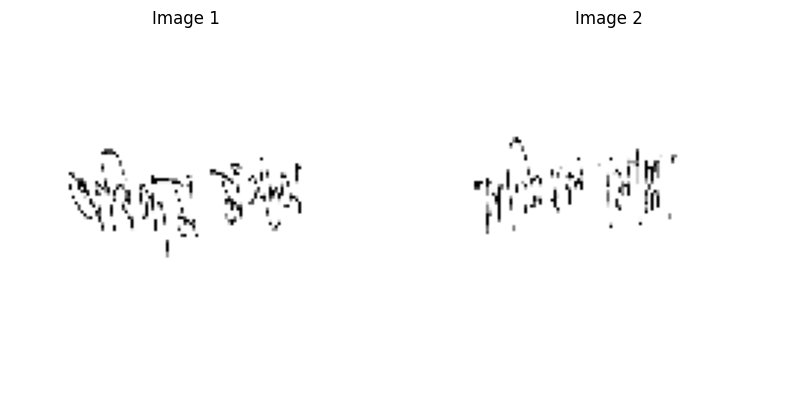

SSIM Score: 0.8032520352380242


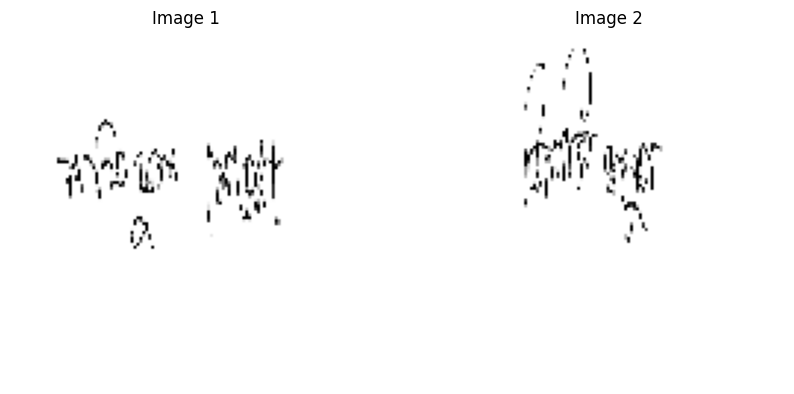

SSIM Score: 0.7744286254274169


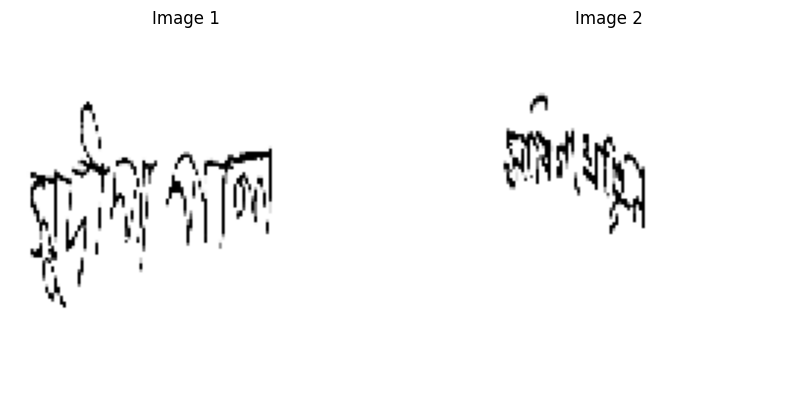

SSIM Score: 0.7136303045170235


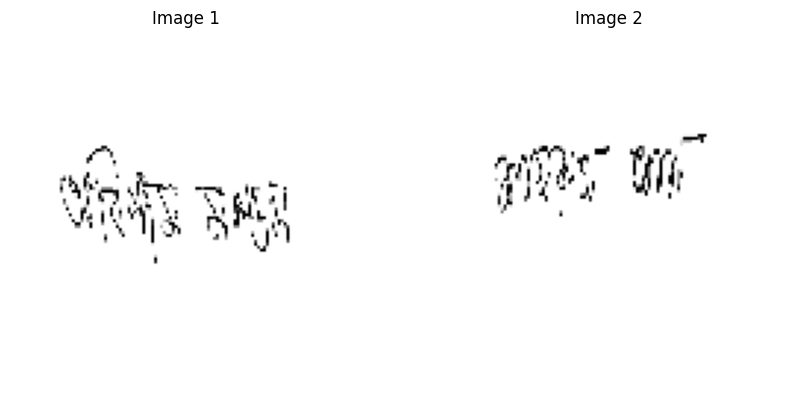

SSIM Score: 0.7901159609989635


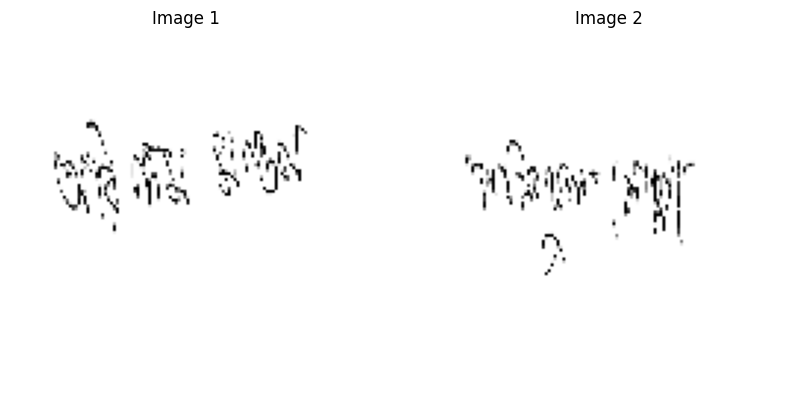

SSIM Score: 0.7790570920377867


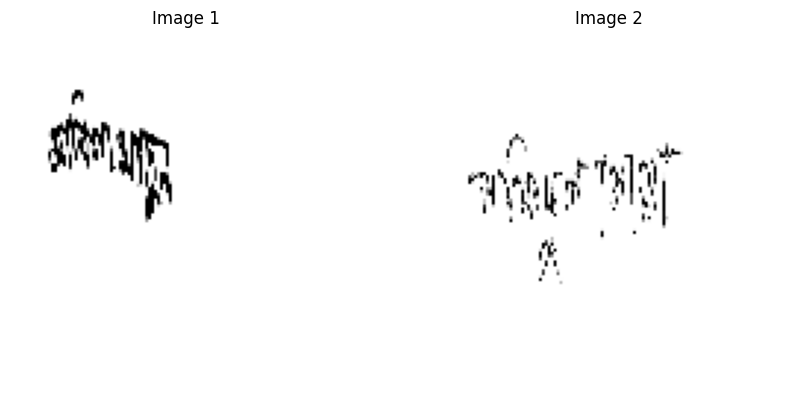

SSIM Score: 0.7896400471088181


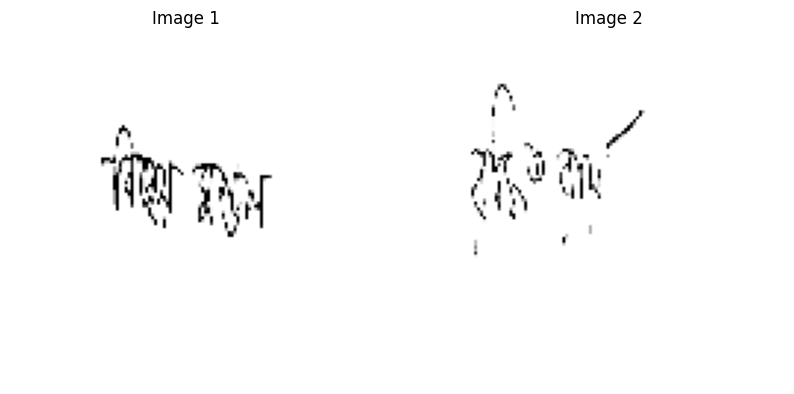

SSIM Score: 0.7933812615983661


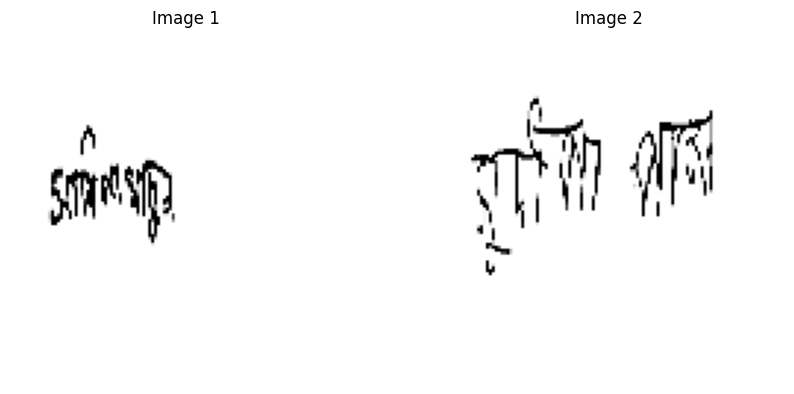

SSIM Score: 0.7647304835023087


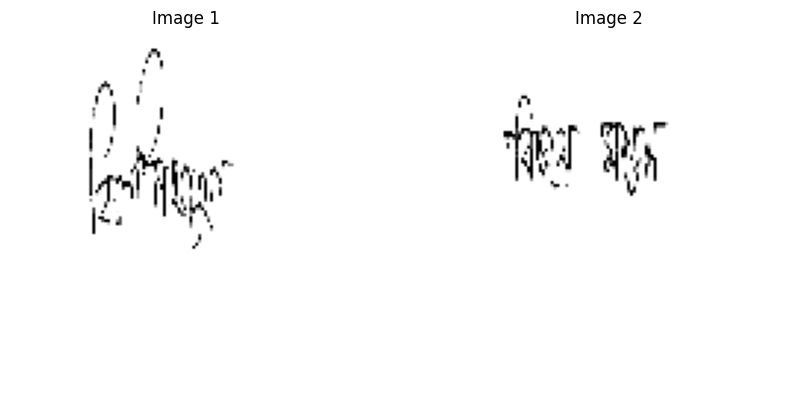

SSIM Score: 0.8069533124023529


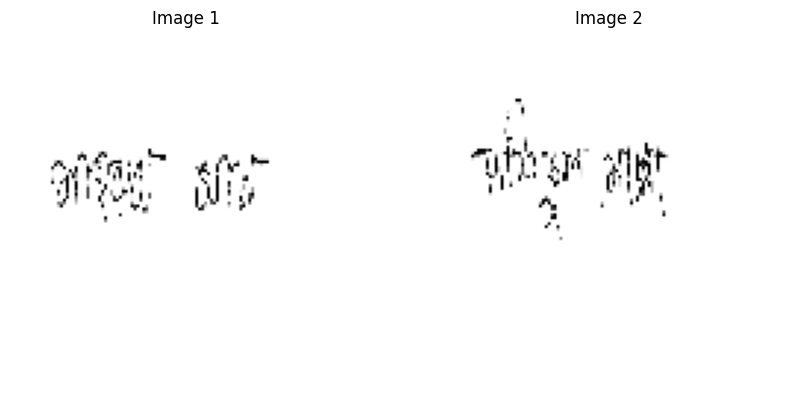

SSIM Score: 0.8401160683697944


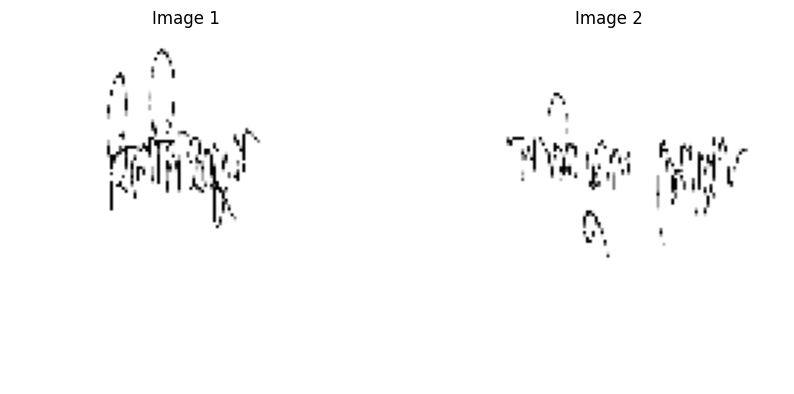

SSIM Score: 0.7690911863123361


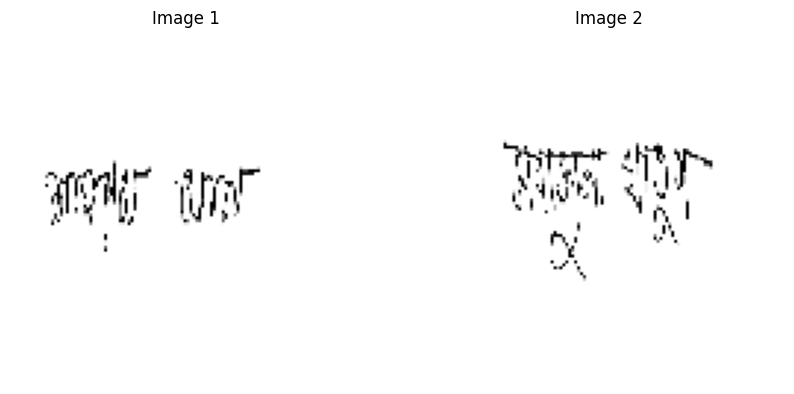

SSIM Score: 0.7854547047343652


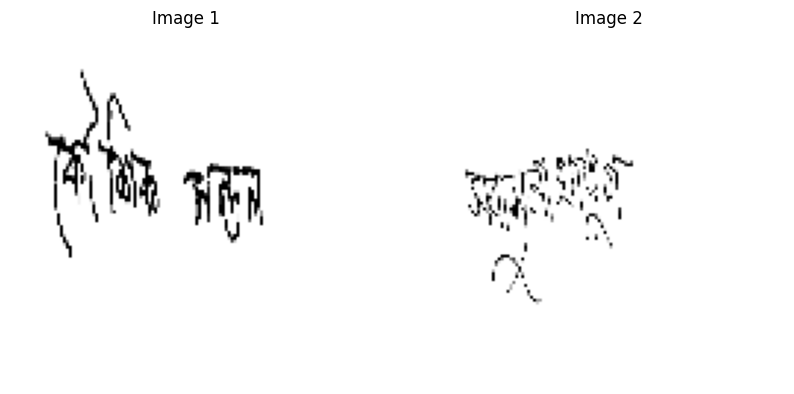

SSIM Score: 0.7555656558145851


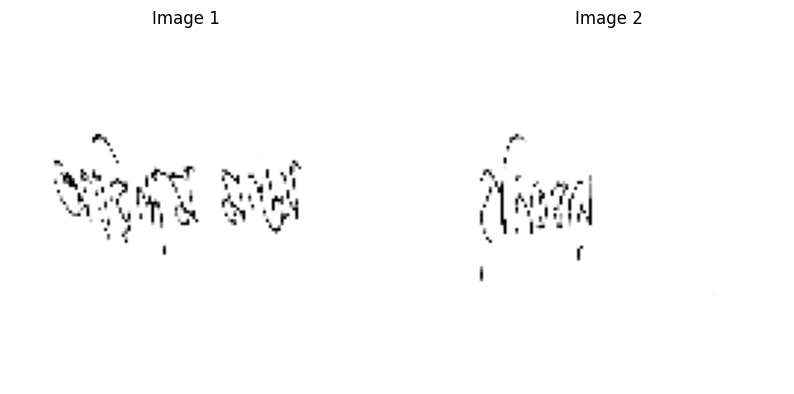

SSIM Score: 0.810532937895323


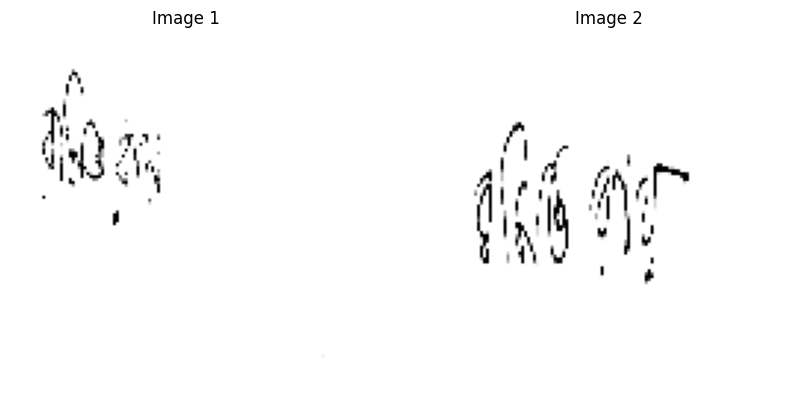

SSIM Score: 0.7479489374532239


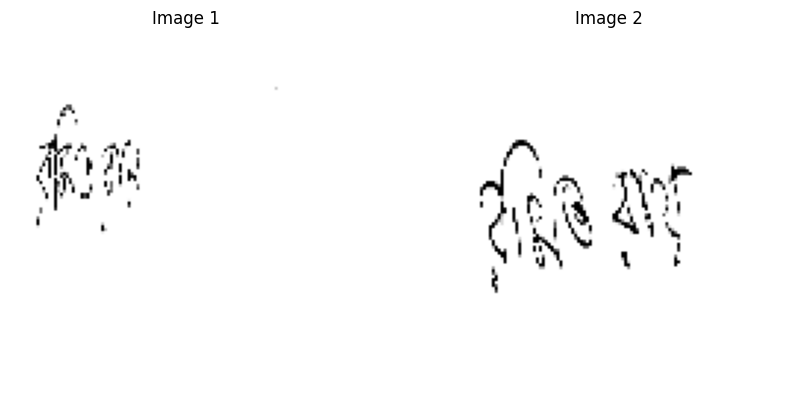

SSIM Score: 0.7579182369797687


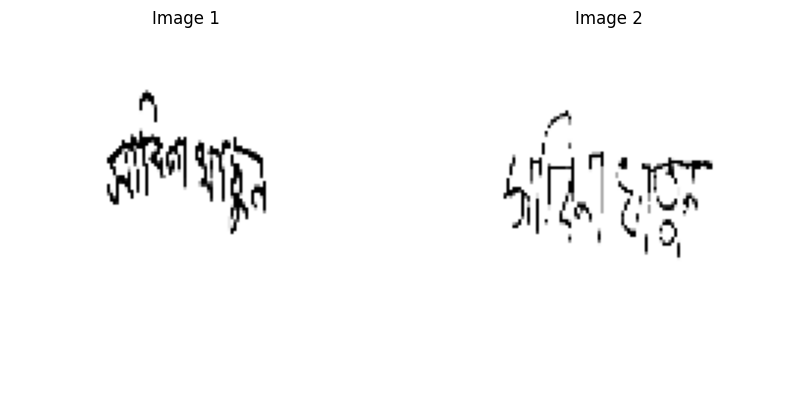

SSIM Score: 0.7881735178362139


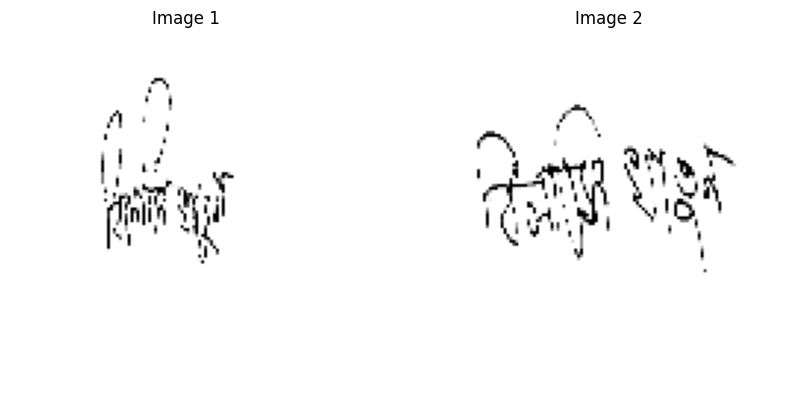

SSIM Score: 0.7145212238468218


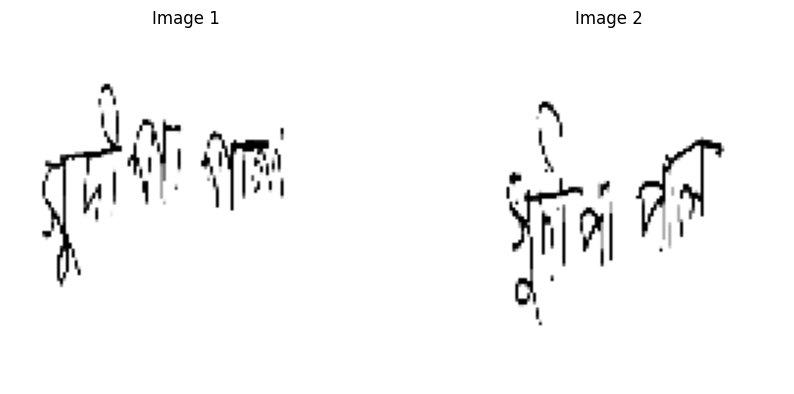

SSIM Score: 0.6721676988062059


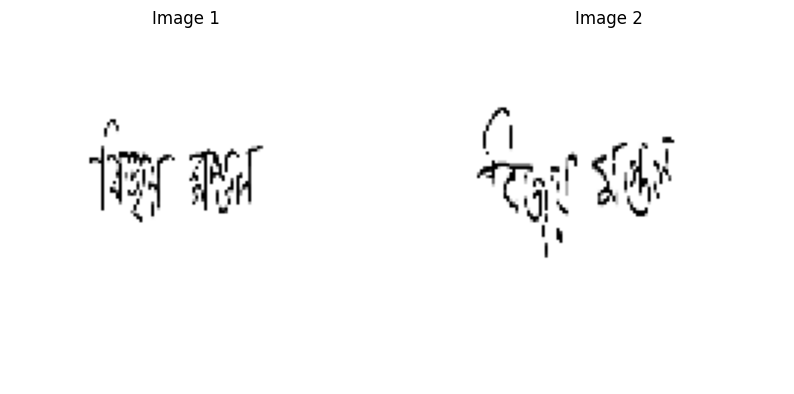

SSIM Score: 0.8204204489297888


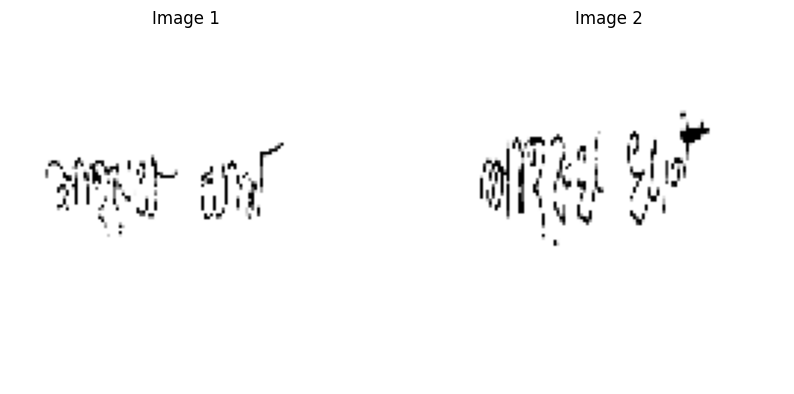

SSIM Score: 0.8023937700567542


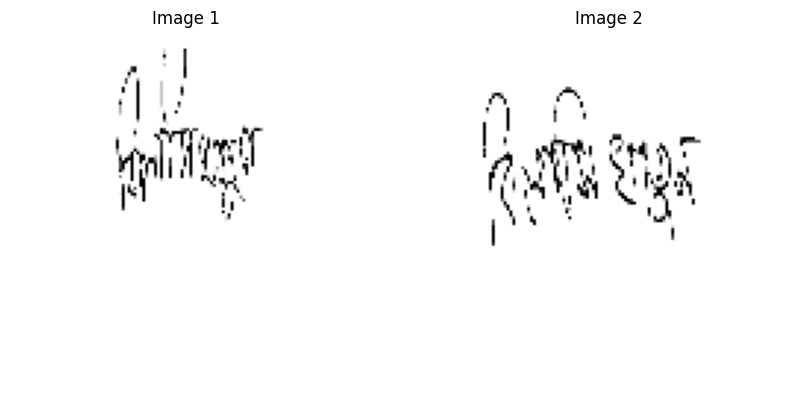

SSIM Score: 0.7474436785770693


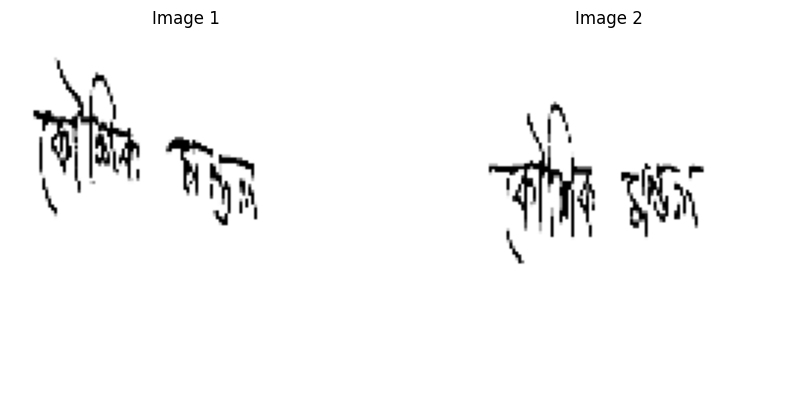

SSIM Score: 0.727561163408326


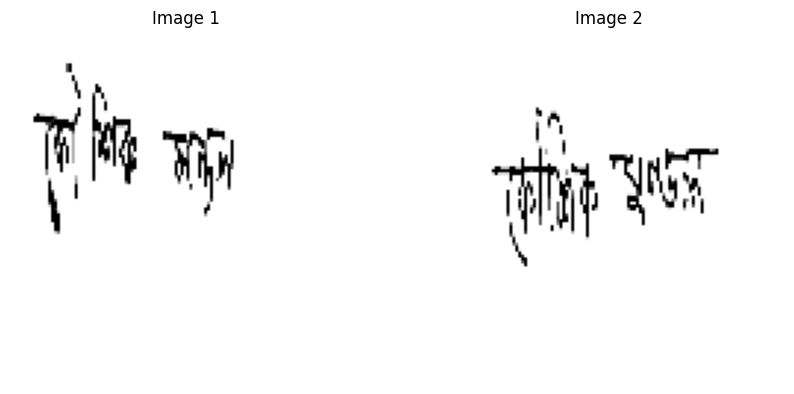

SSIM Score: 0.7257543907247265


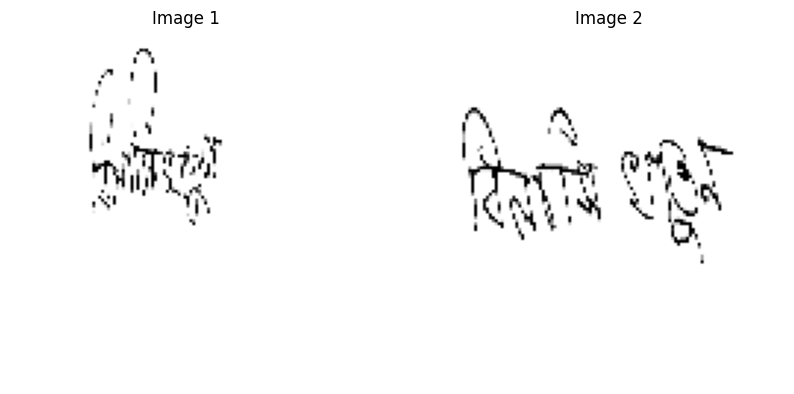

SSIM Score: 0.694634353646034


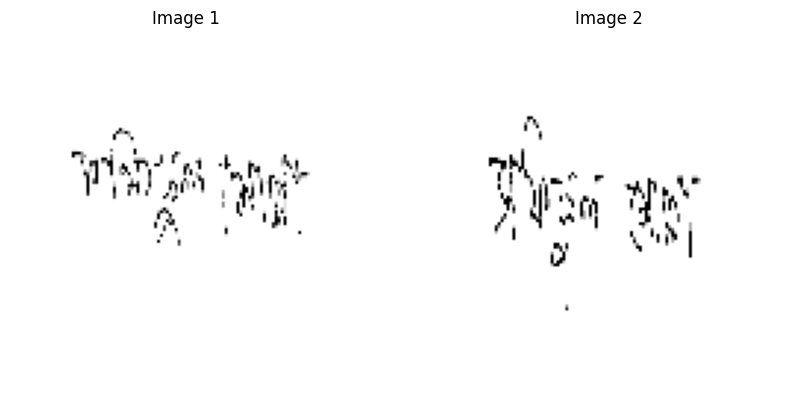

SSIM Score: 0.7716098027212185


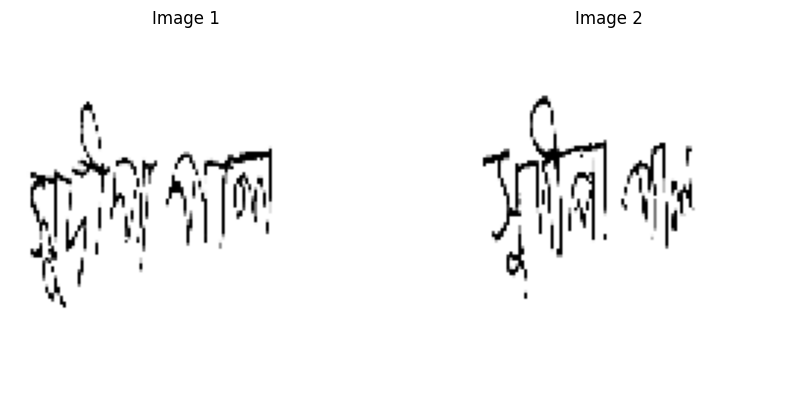

SSIM Score: 0.6903983901619055


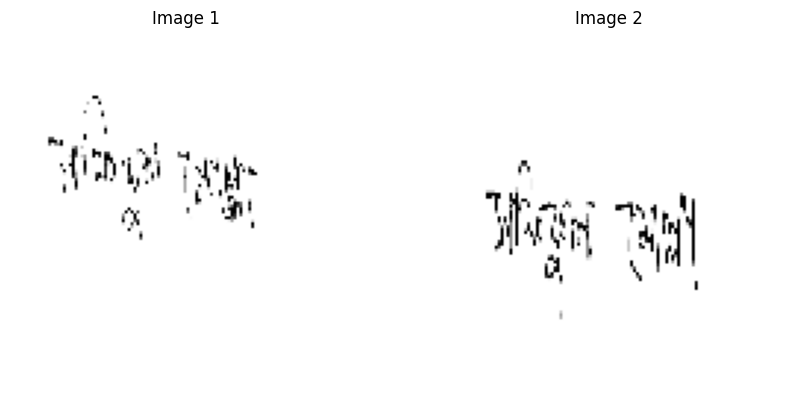

SSIM Score: 0.7475132592309771


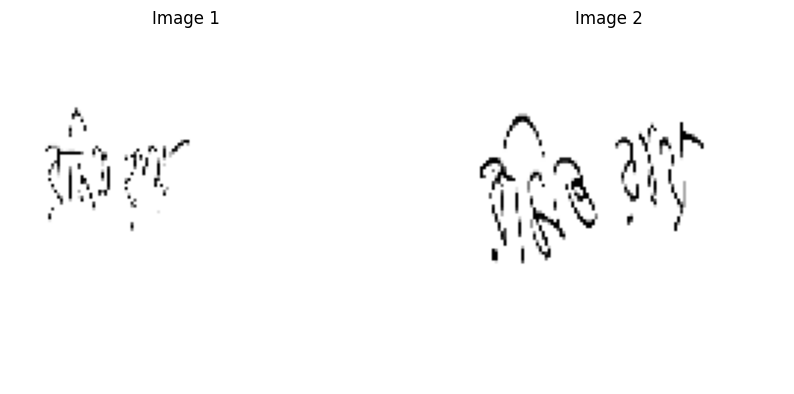

SSIM Score: 0.7713098018853715


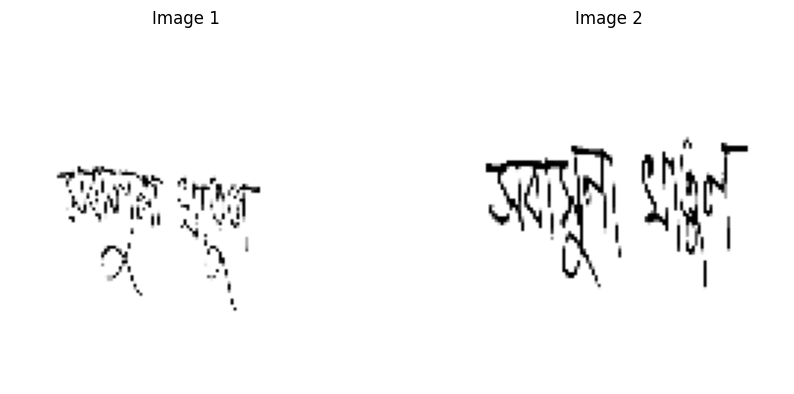

SSIM Score: 0.7053176265544746
Average SSIM Score: 0.7629769372293859


In [ ]:
import numpy as np
from skimage.metrics import structural_similarity as compare_ssim
import matplotlib.pyplot as plt
import cv2

def predict_score(model, test_data_inputs, img_h, img_w):
    '''Predict distance score and classify test images as Genuine or Forged'''
    num_images = test_data_inputs[0].shape[0]
    ssim_scores = []

    for i in range(num_images):
        img1, img2 = test_data_inputs[0][i], test_data_inputs[1][i]

        # Check if the images are at least 7x7 pixels
        if img1.shape[0] < 7 or img1.shape[1] < 7 or img2.shape[0] < 7 or img2.shape[1] < 7:
            print("Error: Image dimensions are too small for SSIM calculation.")
            continue

        # Display the two images
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
        ax1.imshow(img1.squeeze(), cmap='gray')
        ax2.imshow(img2.squeeze(), cmap='gray')
        ax1.set_title('Image 1')
        ax2.set_title('Image 2')
        ax1.axis('off')
        ax2.axis('off')
        plt.show()

        # Compute SSIM between the two images with adjusted win_size parameter
        win_size = min(img1.shape[0], img1.shape[1], img2.shape[0], img2.shape[1], 7)
        ssim_score = compare_ssim(img1.squeeze(), img2.squeeze(), win_size=win_size, multichannel=True)
        print("SSIM Score:", ssim_score)
        ssim_scores.append(ssim_score)

    avg_ssim_score = np.mean(ssim_scores)
    print("Average SSIM Score:", avg_ssim_score)

# Call the function
predict_score(model, test_batch_inputs, img_h, img_w)


In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Optimal Threshold:", optimal_threshold)
print("ROC AUC:", roc_auc)

Accuracy: 0.84375
Precision: 0.7894736842105263
Recall: 0.9375
F1-Score: 0.8571428571428572
Optimal Threshold: 0.5685802
ROC AUC: 0.8203125


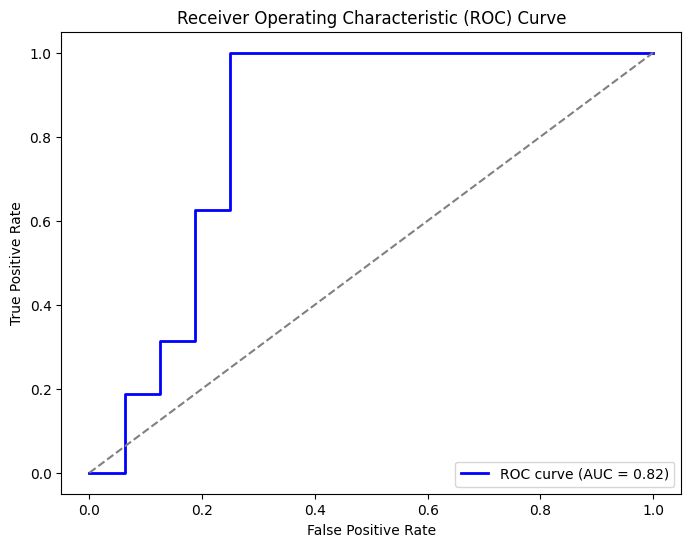

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(test_batch_labels, predictions)

# Compute ROC AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Print paths of all images in the test set
for orig_group, forg_group in zip(orig_test, forg_test):
    print("Originals:")
    for img_path in orig_group:
        print(img_path)
    print("Forged:")
    for img_path in forg_group:
        print(img_path)


Originals:
/content/drive/MyDrive/Multilingual dataset/BHSig260-Bengali/76/B-S-76-G-01.tif
/content/drive/MyDrive/Multilingual dataset/BHSig260-Bengali/76/B-S-76-G-02.tif
/content/drive/MyDrive/Multilingual dataset/BHSig260-Bengali/76/B-S-76-G-03.tif
/content/drive/MyDrive/Multilingual dataset/BHSig260-Bengali/76/B-S-76-G-04.tif
/content/drive/MyDrive/Multilingual dataset/BHSig260-Bengali/76/B-S-76-G-05.tif
/content/drive/MyDrive/Multilingual dataset/BHSig260-Bengali/76/B-S-76-G-06.tif
/content/drive/MyDrive/Multilingual dataset/BHSig260-Bengali/76/B-S-76-G-07.tif
/content/drive/MyDrive/Multilingual dataset/BHSig260-Bengali/76/B-S-76-G-08.tif
/content/drive/MyDrive/Multilingual dataset/BHSig260-Bengali/76/B-S-76-G-09.tif
/content/drive/MyDrive/Multilingual dataset/BHSig260-Bengali/76/B-S-76-G-10.tif
/content/drive/MyDrive/Multilingual dataset/BHSig260-Bengali/76/B-S-76-G-11.tif
/content/drive/MyDrive/Multilingual dataset/BHSig260-Bengali/76/B-S-76-G-12.tif
/content/drive/MyDrive/Multil

In [ ]:
# Print the test batch inputs, predictions, and labels
print("Test Batch Inputs:")
print(test_batch_inputs)
print("Predictions:")
print(predictions)
print("Ground Truth Labels:")
print(test_batch_labels)


Test Batch Inputs:
[array([[[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        ...,

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]],


       [[[1., 1., 1.],
         [1., 1.,